In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
fred = Fred(api_key='388e4633f23c88b89679b89794f572ed')

# Initial analysis


In [3]:
consumerloans = fred.get_series('CCLACBW027SBOG')
consumerloans
# first date is 2000-06-28, last is 2024-04-10

2000-06-28     211.4984
2000-07-05     212.0107
2000-07-12     210.8742
2000-07-19     212.5366
2000-07-26     211.7712
                ...    
2024-03-13    1053.4000
2024-03-20    1054.5657
2024-03-27    1053.8033
2024-04-03    1054.3702
2024-04-10    1052.6077
Length: 1242, dtype: float64

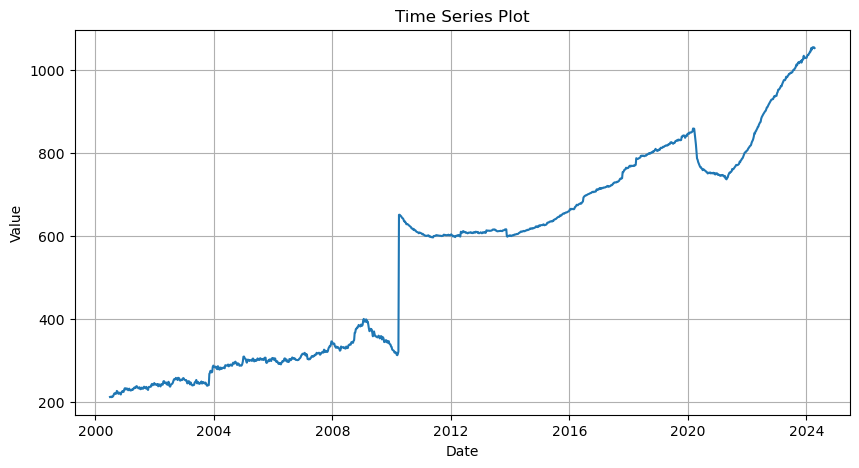

In [4]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()